In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 1.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import count
%matplotlib inline

from gymnasium.wrappers.record_video import RecordVideo

1. makes update per 32 steps == 1 batch

In [ ]:
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        #print(i, 'AAAAAAAAAAAAAAA')
        #assert 0 <= i < 5
        #assert (0 <= i < 5).all
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended                             #reversed(out)

def onehot(idx, dim):
    vec = torch.zeros(dim)
    #print(idx, 'INDEX')
    vec[idx] = 1.
    return vec

def OHE_state(state):
    taxi_row, taxi_col, pass_loc, dest_idx = decode(state)
    #print('--------------', state, taxi_row, taxi_col)
    taxi_row, taxi_col, pass_loc, dest_idx = taxi_row.numpy(), taxi_col.numpy(), pass_loc.numpy(), dest_idx.numpy()
    #print(taxi_row, taxi_col, pass_loc, dest_idx)

    oh_taxi_x = onehot(taxi_row, 5)
    oh_taxi_y = onehot(taxi_col, 5)
    oh_pass_loc = onehot(pass_loc, 5)
    oh_dest_loc = onehot(dest_idx, 4)
    oh_all = torch.cat([torch.tensor(oh_taxi_x), torch.tensor(oh_taxi_y), torch.tensor(oh_pass_loc), torch.tensor(oh_dest_loc)], 0)
    return oh_all

def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: states, actions, rewards, next_actions, terminateds
    ####### Здесь ваш код ########
    n_samples = min(len(replay_buffer), n_samples)

    indices = np.random.choice(len(replay_buffer), n_samples, replace=False)
    states, actions, rewards, next_actions, terminateds = [], [], [], [], []
    for i in indices:
        s, a, r, n_s, done = replay_buffer[i]
        states.append(s)
        actions.append(a)
        rewards.append(r)
        next_actions.append(n_s)
        terminateds.append(done)
    ##############################

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_actions), np.array(terminateds)

def rescale_reward(reward):
    if reward==-10:
        reward_out=-.1
    elif reward==20:
        reward_out=1
    elif reward==-1:
        reward_out=0

    else:
        raise NotImplementedError

    return reward_out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-3-c6c8a52a0d72>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  oh_all = torch.cat([torch.tensor(oh_taxi_x), torch.tensor(oh_taxi_y), torch.tensor(oh_pass_loc), torch.tensor(oh_dest_loc)], 0)


19 128
128 128
global_step=1000 | avg_return=-209.000
global_step=2000 | avg_return=-209.000
global_step=3000 | avg_return=-206.000
global_step=4000 | avg_return=-204.500
global_step=5000 | avg_return=-203.600
global_step=6000 | avg_return=-201.800
global_step=7000 | avg_return=-200.000
global_step=8000 | avg_return=-200.000
global_step=9000 | avg_return=-200.000
global_step=10000 | avg_return=-200.000
global_step=11000 | avg_return=-200.000
global_step=12000 | avg_return=-200.000
global_step=13000 | avg_return=-200.000
global_step=14000 | avg_return=-200.000
global_step=15000 | avg_return=-200.000
global_step=16000 | avg_return=-200.000
global_step=17000 | avg_return=-200.000
global_step=18000 | avg_return=-200.000
global_step=19000 | avg_return=-200.000
global_step=20000 | avg_return=-200.000
global_step=21000 | avg_return=-200.000
global_step=22000 | avg_return=-200.000
global_step=23000 | avg_return=-200.000
global_step=24000 | avg_return=-200.000
global_step=25000 | avg_return=-20

KeyboardInterrupt: ignored

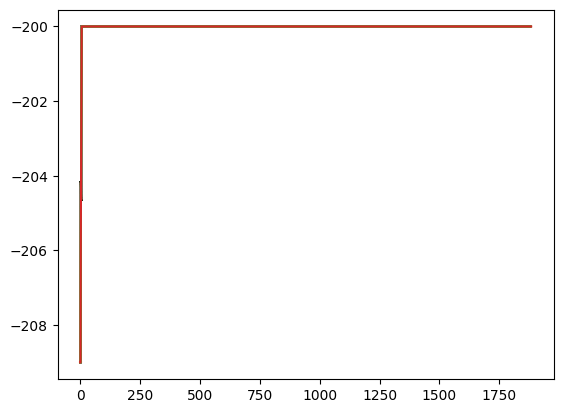

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

import gymnasium as gym
from gymnasium.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple

from collections import deque

EMBED_STATE_DIM = 19

def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

class ActorBatch:
    def __init__(self):
        self.logprobs = []
        self.q_values = []

    def append(self, log_prob, q_value):
        self.logprobs.append(log_prob)
        self.q_values.append(q_value)

    def clear(self):
        self.logprobs.clear()
        self.q_values.clear()


class ActorCriticModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()

        # Инициализируйте сеть агента с двумя головами: softmax-актора и линейного критика
        # self.net, self.actor_head, self.critic_head =
        ####### Здесь ваш код ########
        from_dim = input_dim
        layers = []
        #print(hidden_dims)
        for to_dim in hidden_dims:
            print(from_dim, to_dim)
            layers.extend([
                nn.Linear(from_dim, to_dim),
                nn.Tanh()
            ])
            from_dim = to_dim

        self.net = nn.Sequential(*layers)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
        )
        # self.actor_head = nn.Sequential(
        #     create_network(input_dim, hidden_dims, output_dim),
        #     nn.Softmax(dim=-1)
        # )
        # self.critic_head = create_network(input_dim, hidden_dims, output_dim)
        ##############################

    def forward(self, state):
        # Вычислите выбранное действие, логарифм вероятности его выбора и соответствующее значение Q-функции
        ####### Здесь ваш код ########
        #state = OHE_state(state)
        state = self.net(state)

        action_probs = self.actor_head(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        q_values = self.critic_head(state)

        log_prob = dist.log_prob(action)
        action = action.item()
        # adv = q_values[action] - torch.sum(q_values * action_probs, -1)
        q_value = q_values[action]
        ##############################

        return action, log_prob, q_value

    def evaluate(self, state):
        # Вычислите значения Q-функции для данного состояния
        ####### Здесь ваш код ########
        #state = OHE_state(state)
        decoded_states = torch.stack([OHE_state(s_i) for s_i in state], 1).T
        #print('QQQQQQQQQQQQQQQQQQQQQQQQQQQQq', state.shape)
        state = self.net(decoded_states) #!

        q_values = self.critic_head(state)
        ##############################
        return q_values


class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_dims, lr, gamma, critic_rb_size):
        self.lr = lr
        self.gamma = gamma

        # Инициализируйте модель актор-критика и SGD оптимизатор (например, `torch.optim.Adam)`)
        ####### Здесь ваш код ########
        self.actor_critic = ActorCriticModel(state_dim, hidden_dims, action_dim)
        self.actor_opt = self.critic_opt = self.opt = torch.optim.Adam(self.actor_critic.parameters(), lr=lr)
        # self.actor_opt = torch.optim.Adam(self.actor_critic.actor_head.parameters(), lr=lr)
        # self.critic_opt = torch.optim.Adam(self.actor_critic.critic_head.parameters(), lr=lr*.25)
        ##############################

        self.actor_batch = ActorBatch()
        self.critic_rb = deque(maxlen=critic_rb_size)

    def act(self, state):
        # Произведите выбор действия и сохраните необходимые данные в батч для последующего обучения
        # Не забудьте сделать q_value.detach()
        # self.actor_batch.append(..)
        ####### Здесь ваш код ########
        action, logprob, q_value = self.actor_critic(OHE_state(to_tensor(state))) #!
        self.actor_batch.append(logprob, q_value.detach())

        # action = select_action_eps_greedy(self.actor_critic.critic_head, state, 0.05)
        ##############################

        return action

    def append_to_replay_buffer(self, s, a, r, next_s, terminated):
        # Добавьте новый экземпляр данных в память прецедентов.
        ####### Здесь ваш код ########
        self.critic_rb.append((s, a, r, next_s, terminated))
        ##############################

    def evaluate(self, state):
        #decoded_states = torch.stack([OHE_state(s_i) for s_i in state], 1)
        return self.actor_critic.evaluate(state) #!
        #return self.actor_critic.evaluate(decoded_states) #!

    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)

    def update_actor(self):
        #print(self.actor_batch.q_values, 'Q_VALUES')
        #print(self.actor_batch.q_values.shape, 'Q shape')
        #recoded_states=to_tensor( [recode_state(states[i]) for i in range(len(states))] )
        #print(recoded_states.shape)
        #Q_sa=agent_network(recoded_states)

        Q_s_a = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs)

        # Реализуйте шаг обновления актора — вычислите ошибку `loss` и произведите шаг обновления градиентным спуском.
        # Опционально: сделайте нормализацию отдач
        ####### Здесь ваш код ########
        # Нормализация отдач
        Q_s_a = (Q_s_a - Q_s_a.mean()) / (Q_s_a.std() + 1e-7)

        # Считаем ошибку
        loss = torch.mean(-logprobs * Q_s_a)

        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        self.actor_batch.clear()
        ##############################

    def update_critic(self, batch_size, n_updates=1):
        # Реализуйте n_updates шагов обучения критика.
        ####### Здесь ваш код ########

        if len(self.critic_rb) < batch_size:
            return

        for _ in range(n_updates):
            train_batch = sample_batch(self.critic_rb, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch

            self.critic_opt.zero_grad()
            loss = self.compute_td_loss(states, actions, rewards, next_states, terminateds)
            loss.backward()
            self.critic_opt.step()
        ##############################

    def compute_td_loss(
        self, states, actions, rewards, next_states, terminateds, regularizer=.1
    ):
        # переводим входные данные в тензоры
        s = to_tensor(states)                     # shape: [batch_size, state_size]
        #s = OHE_state(s)
        a = to_tensor(actions, int).long()        # shape: [batch_size]
        r = to_tensor(rewards)                    # shape: [batch_size]
        s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
        term = to_tensor(terminateds, bool)       # shape: [batch_size]


        # получаем Q[s, a] для выбранных действий в текущих состояниях (для каждого примера из батча)
        # Q_s_a = ...
        ####### Здесь ваш код ########
        #print(a, 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAACTION')
        #print('STATE', s,s.shape) #(32,)
        #for si in s:
        #  print('kyar', OHE_state(si))
        decoded_states = torch.stack([OHE_state(s_i) for s_i in s], 1).T
        #print('state shape', decoded_states.shape)
        #Q_s_a = torch.gather(self.evaluate(decoded_states), dim=1, index=torch.unsqueeze(a, 1)).squeeze(1)
        Q_s_a = torch.gather(self.evaluate(s), dim=1, index=torch.unsqueeze(a, 1)).squeeze(1)
        ##############################

        # получаем Q[s_next, *] — значения полезности всех действий в следующих состояниях
        # Q_sn = ...,
        # а затем вычисляем V*[s_next] — оптимальные значения полезности следующих состояний
        # V_sn = ...
        ####### Здесь ваш код ########
        with torch.no_grad():
            Q_sn = self.evaluate(s_next)
            V_sn, _ = torch.max(Q_sn, axis=-1)
        ##############################

        # вычисляем TD target и далее TD error
        # target = ...
        # td_error = ...
        ####### Здесь ваш код ########
        target = r + self.gamma * V_sn * torch.logical_not(term)
        td_error = Q_s_a - target
        ##############################

        # MSE loss для минимизации
        loss = torch.mean(td_error ** 2)
        # добавляем регуляризацию на значения Q
        loss += regularizer * Q_s_a.mean()
        return loss


def run_actor_critic(
        env_name='Taxi-v3', #"CartPole-v1",
        hidden_dims=(128, 128), lr=1e-3,
        total_max_steps=10000000,
        # train_schedule=4, replay_buffer_size=4, batch_size=4, critic_updates_per_actor=1,
        train_schedule=32, replay_buffer_size=5000, batch_size=32, critic_updates_per_actor=4,
        eval_schedule=1000, smooth_ret_window=5, success_ret=200.
):
    env = gym.make(env_name)
    episode_return_history = deque(maxlen=smooth_ret_window)

    agent = ActorCriticAgent(
        state_dim = EMBED_STATE_DIM, action_dim=env.action_space.n, hidden_dims=hidden_dims,
        lr=lr, gamma=.995, critic_rb_size=replay_buffer_size
    )

    s, _ = env.reset()
    done, episode_return = False, 0.
    eval = False

    Returns = [] #❤️😍😩😭☺️
    for global_step in range(1, total_max_steps+1):
        #print(s)
        a = agent.act(s)
        s_next, r, terminated, truncated, _ = env.step(a)
        #r = rescale_reward(r)
        episode_return += r
        done = terminated or truncated

        # train step
        agent.append_to_replay_buffer(s, a, r, s_next, terminated)
        agent.update(train_schedule, batch_size, critic_updates_per_actor)

        # evaluate
        if global_step % eval_schedule == 0:
            eval = True

        s = s_next
        if done:
            if eval:
                #print('qq im here')
                episode_return_history.append(episode_return)
                avg_return = np.mean(episode_return_history)
                print(f'{global_step=} | {avg_return=:.3f}')
                Returns.append(avg_return)
                if avg_return >= success_ret:
                    print('Решено!')
                    break
                if global_step % 100 == 0:
                  plt.plot(Returns)
            #print('done qq')
            s, _ = env.reset()
            done, episode_return = False, 0.
            eval = False

run_actor_critic()

In [ ]:
OHE_state(87).shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([19])

In [ ]:
print(env.observation_space)

Discrete(500)


In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array", max_episode_steps=400)
env.reset(seed=87)
#print()
plt.imshow(env.render())

In [ ]:
print(env.s)

284


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_attr('s')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
print(env.reset(seed=87))

(284, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(env.desc)

[[b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']
 [b'|' b'R' b':' b' ' b'|' b' ' b':' b' ' b':' b'G' b'|']
 [b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b':' b' ' b':' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b'|']
 [b'|' b'Y' b'|' b' ' b':' b' ' b'|' b'B' b':' b' ' b'|']
 [b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_attr('desc')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
print(env.locs)

[(0, 0), (0, 4), (4, 0), (4, 3)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.locs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.locs` for environment variables or `env.get_attr('locs')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
print(env.P)

{0: {0: [(1.0, 100, -1, False)], 1: [(1.0, 0, -1, False)], 2: [(1.0, 20, -1, False)], 3: [(1.0, 0, -1, False)], 4: [(1.0, 16, -1, False)], 5: [(1.0, 0, -10, False)]}, 1: {0: [(1.0, 101, -1, False)], 1: [(1.0, 1, -1, False)], 2: [(1.0, 21, -1, False)], 3: [(1.0, 1, -1, False)], 4: [(1.0, 17, -1, False)], 5: [(1.0, 1, -10, False)]}, 2: {0: [(1.0, 102, -1, False)], 1: [(1.0, 2, -1, False)], 2: [(1.0, 22, -1, False)], 3: [(1.0, 2, -1, False)], 4: [(1.0, 18, -1, False)], 5: [(1.0, 2, -10, False)]}, 3: {0: [(1.0, 103, -1, False)], 1: [(1.0, 3, -1, False)], 2: [(1.0, 23, -1, False)], 3: [(1.0, 3, -1, False)], 4: [(1.0, 19, -1, False)], 5: [(1.0, 3, -10, False)]}, 4: {0: [(1.0, 104, -1, False)], 1: [(1.0, 4, -1, False)], 2: [(1.0, 24, -1, False)], 3: [(1.0, 4, -1, False)], 4: [(1.0, 4, -10, False)], 5: [(1.0, 4, -10, False)]}, 5: {0: [(1.0, 105, -1, False)], 1: [(1.0, 5, -1, False)], 2: [(1.0, 25, -1, False)], 3: [(1.0, 5, -1, False)], 4: [(1.0, 5, -10, False)], 5: [(1.0, 5, -10, False)]}, 6: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
print(env.decode(87))

SyntaxError: ignored

In [ ]:
decode(87)

[0, 4, 1, 3]

In [ ]:
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended #reversed(out)

In [ ]:
print(decode(87))

[0, 4, 1, 3]


In [ ]:
def onehot(idx, dim):
    vec = np.zeros(dim)
    vec[idx] = 1
    return torch.tensor(vec)

def OHE_state2(state):
    taxi_row, taxi_col, pass_loc, dest_idx = decode(state)

    oh_taxi_loc = onehot(taxi_row*5+taxi_col, 25)
    oh_pass_loc = onehot(pass_loc, 5)
    oh_dest_loc = onehot(dest_idx, 4)
    oh_all = torch.cat([oh_taxi_loc, oh_pass_loc, oh_dest_loc], 0)
    return oh_all

print(OHE_state2(87))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       dtype=torch.float64)


In [ ]:
def onehot(idx, dim):
    vec = np.zeros(dim)
    vec[idx] = 1
    return torch.tensor(vec)

def OHE_state(state):
    taxi_row, taxi_col, pass_loc, dest_idx = decode(state)

    oh_taxi_x = onehot(taxi_row, 5)
    oh_taxi_y = onehot(taxi_col, 5)
    oh_pass_loc = onehot(pass_loc, 5)
    oh_dest_loc = onehot(dest_idx, 4)
    oh_all = torch.cat([oh_taxi_x, oh_taxi_y, oh_pass_loc, oh_dest_loc], 0)
    return oh_all

print(OHE_state(87))

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1.], dtype=torch.float64)


In [ ]:
a = torch.randn([2])
b = torch.randn([3])
c = torch.cat([a, b], dim=0)
print(a,b,c)

tensor([-0.4108, -0.6436]) tensor([-0.0264, -0.2528, -0.3976]) tensor([-0.4108, -0.6436, -0.0264, -0.2528, -0.3976])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(OHE_state(87))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


ValueError: ignored